In [107]:
### Master Code
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

save = 0                      #Use save=1 to save the figures that get produced

#The following 4 toggles define which model, training reigmes and loss functions we want to use. 
hierarchical = 1              #Use =0 to use naive model, =1 to use hierarchical.
interleaved = 0              #Use = 1 to train the model on interleaved data set
freezing_regime = 1           #Use =1 to turn on the following freezing scheme
loss_func = 0                 #0 uses MSE loss, 1 uses Binomial Cross Entropy loss (BCE)
    
phase_1 = 0
phase_2 = 0

# Parameters for our model
loss_criterion = 0.02         #Train network to this loss criterion
weight_scaling = 0.0001        #weight_scaling scales all the initialized weights
h1_size = 12
learning_rate = 0.001
momentum_rate = 0.9           #momentum for phase 2
momentum_rate_2 = 0.9         #momentum for phase 2


if hierarchical == 1:
    if interleaved == 0:
        print('Training hierarchical model')
    elif interleaved == 1:
        print('Training interleaved hierarchical model')
if hierarchical == 0:
    if interleaved == 0:
        print('Training naive model')
    elif interleaved == 1:
        print('Training interleaved naive model')

if freezing_regime!=0 and freezing_regime!=1:
    print('Invalid option for freezing_regime selected')
    exit()
if hierarchical!=0 and hierarchical!=1:
    print('Invalid option for hierarchical selected')
    exit()
if loss_func!=0 and loss_func!=1:
    print('Invalid option for loss_func selected')
    exit()
if interleaved!=0 and interleaved!=1:
    print('Invalid option for interleaved selected')
    exit()

#####                                #####
##### Create phase 1 training data:  #####
Phase_1_training_x = torch.zeros(20,24)
Phase_1_training_y = torch.zeros(20,2)                    #One-hot vector output

for i in range(5):
    Phase_1_training_x[(i,i,i+5, i+5, i+10,i+10,i+15,i+15), (i,i+13,i+1,i+12,i+6,i+19,i+7,i+18)] = 1
    Phase_1_training_y[(i,i+5,i+10,i+15),(1,0,1,0)] = 1
    
#Create Object_groupings_input
X_1 = Phase_1_training_x.numpy()
length_X_1 = X_1.shape[0]
Phase_1_object_groupings_np = np.zeros((length_X_1, 4))

for i in range(length_X_1):
    index_X = np.where(X_1[i,:]==1)
    if index_X[0][0] < 6:
        Phase_1_object_groupings_np[i][0]=1
    if 5< index_X[0][0]< 12:
        Phase_1_object_groupings_np[i][1]=1
    if 11<index_X[0][1]<18:
        Phase_1_object_groupings_np[i][2]=1
    if 17<index_X[0][1]< 24:
        Phase_1_object_groupings_np[i][3]=1
    
Phase_1_object_groupings = torch.from_numpy(Phase_1_object_groupings_np).type(torch.FloatTensor)


#####                                  #####
#####  Create Phase 2 training data:   #####
Phase_2_training_x = torch.zeros(2,24)
Phase_2_training_x[(0,0,1,1),(5,18,6,17)] = 1

Phase_2_training_y = torch.zeros(2,2)
Phase_2_training_y[(0,1),(1,0)]=1

#Create Object_groupings_input
X_2 = Phase_2_training_x.numpy()
length_X_2 = X_2.shape[0]
Phase_2_object_groupings_np = np.zeros((length_X_2, 4))

for i in range(length_X_2):
    index_X = np.where(X_2[i,:]==1)
    if index_X[0][0] < 6:
        Phase_2_object_groupings_np[i][0]=1
    if 5< index_X[0][0]< 12:
        Phase_2_object_groupings_np[i][1]=1
    if 11<index_X[0][1]<18:
        Phase_2_object_groupings_np[i][2]=1
    if 17<index_X[0][1]< 24:
        Phase_2_object_groupings_np[i][3]=1
    
Phase_2_object_groupings = torch.from_numpy((Phase_2_object_groupings_np)).type(torch.FloatTensor)

#####                                   #####
##### Create Interleaved training data  #####
Interleaved_x = torch.cat((Phase_1_training_x, Phase_2_training_x), dim=0)
Interleaved_y = torch.cat((Phase_1_training_y, Phase_2_training_y), dim=0)
Interleaved_groupings = torch.cat((Phase_1_object_groupings,Phase_2_object_groupings), dim=0)

#####                               #####
#####    Create the testing data    #####
Test_x = torch.tensor([])
for i in range(24):
    if i<6:
        for j in range(12,24):
            new_row = torch.zeros(1,24)
            new_row[(0,0),(i,j)]=1
            Test_x = torch.cat((Test_x, new_row), dim=0)
            
    if 5<i<12:
        for j in range(12,24):
            new_row = torch.zeros(1,24)
            new_row[(0,0),(i,j)]=1
            Test_x = torch.cat((Test_x, new_row), dim=0)
                   
X_test = Test_x.numpy()
length_X_test = X_test.shape[0]
Test_object_groupings_np = np.zeros((length_X_test,4))

for i in range(length_X_test):
    index_X = np.where(X_test[i,:]==1)
    if index_X[0][0] < 6:
        Test_object_groupings_np[i][0]=1
    if 5< index_X[0][0]< 12:
        Test_object_groupings_np[i][1]=1
    if 11<index_X[0][1]<18:
        Test_object_groupings_np[i][2]=1
    if 17<index_X[0][1]< 24:
        Test_object_groupings_np[i][3]=1
        
Test_object_groupings = torch.from_numpy(Test_object_groupings_np).type(torch.FloatTensor)



#####                               #####
#####  Specify our neural networks  #####
class Naive_Model(nn.Module):
    def __init__(self, h1_size, weight_scaling):
        super(Naive_Model, self).__init__()
        self.layer1 = nn.Linear(24, h1_size, bias=True)
        self.layer2a = nn.Linear(h1_size, 2, bias=False)
        self.layer2b = nn.Linear(1, 1, bias=False)     #Note this is just a placeholder, layer2b doesn't get used for this model
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()
        #scale the weights
        with torch.no_grad():
            self.layer1.weight.mul_(weight_scaling)
            self.layer2a.weight.mul_(weight_scaling)        
    def forward(self, x, y):        
        h1 = self.layer1(x)
        h1 = self.sigmoid(h1)
        out = self.layer2a(h1)
        out = self.softmax(out)
        return h1, out
    
class Hierarchical_Model(nn.Module):
    def __init__(self, h1_size, freezing_regime, weight_scaling):
        super(Hierarchical_Model, self).__init__()
        self.layer1 = nn.Linear(24, h1_size, bias=False)
        self.layer2a = nn.Linear(h1_size, 2, bias=False)
        self.layer2b = nn.Linear(4,2,bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()       
        #scale the weights
        with torch.no_grad():
            self.layer1.weight.mul_(weight_scaling)
            self.layer2a.weight.mul_(weight_scaling)
            if freezing_regime==0:
                self.layer2b.weight.mul_(weight_scaling)
            elif freezing_regime==1:
                self.layer2b.weight.mul_(0)        
    def forward(self, x,y):
        h1 = self.layer1(x)
        h1 = self.sigmoid(h1)
        out = self.layer2a(h1) + self.layer2b(y)
        out = self.softmax(out)
        return h1, out

if hierarchical == 0:
    model = Naive_Model(h1_size, weight_scaling)
if hierarchical == 1:
    model = Hierarchical_Model(h1_size, freezing_regime, weight_scaling)

#Set loss function to be used.
if loss_func == 0:
    criterion = nn.MSELoss()
elif loss_func == 1:
    criterion = nn.BCELoss()
    
if freezing_regime == 1:
    model.layer2b.weight.requires_grad = False

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum_rate)
    
def add_term(x,y): 
    out = torch.cat((x, torch.unsqueeze(y, 0)),0)
    return out
#####                               #####
#####   Training on Phase_1 data:   #####
#Creating Tensors to store the layer weights history
Phase_1_w1_history = torch.tensor([])
Phase_1_w2a_history = torch.tensor([])
Phase_1_h1_history = torch.tensor([])

Phase_1_loss_array = np.array([])
loss = 1
meta_count = 0
while loss > loss_criterion:
    num_epochs_1 = 1000
    for epoch in range(num_epochs_1):
        
        if interleaved == 0:
            hidden_1 , outputs = model(Phase_1_training_x, Phase_1_object_groupings)
            loss = criterion(outputs, Phase_1_training_y)
        elif interleaved ==1 :
            hidden_1 , outputs = model(Interleaved_x, Interleaved_groupings)
            loss = criterion(outputs, Interleaved_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()

        if (epoch+num_epochs_1)%num_epochs_1 ==0:
            Phase_1_loss_array = np.append(Phase_1_loss_array, np.array([loss]))
            with torch.no_grad():
                Phase_1_w1_history = add_term(Phase_1_w1_history, model.layer1.weight)
                Phase_1_w2a_history = add_term(Phase_1_w2a_history, model.layer2a.weight)
                Phase_1_h1_history = add_term(Phase_1_h1_history, hidden_1)
            with torch.no_grad():
                W1_grad_norm = torch.norm(model.layer1.weight.grad)
                W1_scaled = W1_grad_norm/np.sqrt(list(model.layer1.weight.grad.shape)[0]*list(model.layer1.weight.grad.shape)[1])
                W2a_grad_norm = torch.norm(model.layer2a.weight.grad)
                W2a_scaled = W2a_grad_norm/np.sqrt(list(model.layer2a.weight.grad.shape)[0]*list(model.layer2a.weight.grad.shape)[1])
            print ('Phase 1, Index:{}, Epoch: {}, Loss: {:.4f}, W1 measure: {:.10f}, W2 measure: {:.10f}' 
                   .format(meta_count+1, epoch + num_epochs_1*meta_count , loss.item(), W1_scaled, W2a_scaled))
            meta_count +=1


#Testing the data post training for phase 1:
Phase_1_h1, Phase_1_test_output = model(Test_x, Test_object_groupings)

phase_1 = 1

#####                               #####
#####      Plotting this result     #####
y_data = Phase_1_test_output.detach().numpy()
y_data_1 = y_data[0:72, 1]                      
y_data_2 = y_data[72:144, 1]
Phase_1_decision_matrix = np.zeros((12,12))
for i in range(6):
    Phase_1_decision_matrix[:][i] = y_data_1[i*12:(i+1)*12]
for i in range(6):
    Phase_1_decision_matrix[:][i+6] = y_data_2[i*12:(i+1)*12]

Training hierarchical model
Phase 1, Index:1, Epoch: 0, Loss: 0.2500, W1 measure: 0.0000000464, W2 measure: 0.0000012012
Phase 1, Index:2, Epoch: 1000, Loss: 0.2500, W1 measure: 0.0000000470, W2 measure: 0.0000000730
Phase 1, Index:3, Epoch: 2000, Loss: 0.2500, W1 measure: 0.0000000488, W2 measure: 0.0000000855
Phase 1, Index:4, Epoch: 3000, Loss: 0.2500, W1 measure: 0.0000000515, W2 measure: 0.0000001025
Phase 1, Index:5, Epoch: 4000, Loss: 0.2500, W1 measure: 0.0000000550, W2 measure: 0.0000001228
Phase 1, Index:6, Epoch: 5000, Loss: 0.2500, W1 measure: 0.0000000595, W2 measure: 0.0000001453
Phase 1, Index:7, Epoch: 6000, Loss: 0.2500, W1 measure: 0.0000000649, W2 measure: 0.0000001716
Phase 1, Index:8, Epoch: 7000, Loss: 0.2500, W1 measure: 0.0000000714, W2 measure: 0.0000001999
Phase 1, Index:9, Epoch: 8000, Loss: 0.2500, W1 measure: 0.0000000790, W2 measure: 0.0000002317
Phase 1, Index:10, Epoch: 9000, Loss: 0.2500, W1 measure: 0.0000000879, W2 measure: 0.0000002676
Phase 1, Index

Phase 1, Index:84, Epoch: 83000, Loss: 0.2354, W1 measure: 0.0007476163, W2 measure: 0.0025937252
Phase 1, Index:85, Epoch: 84000, Loss: 0.2318, W1 measure: 0.0008198138, W2 measure: 0.0028428596
Phase 1, Index:86, Epoch: 85000, Loss: 0.2276, W1 measure: 0.0008926392, W2 measure: 0.0030919672
Phase 1, Index:87, Epoch: 86000, Loss: 0.2226, W1 measure: 0.0009644162, W2 measure: 0.0033334445
Phase 1, Index:88, Epoch: 87000, Loss: 0.2169, W1 measure: 0.0010336150, W2 measure: 0.0035594248
Phase 1, Index:89, Epoch: 88000, Loss: 0.2104, W1 measure: 0.0010992158, W2 measure: 0.0037632368
Phase 1, Index:90, Epoch: 89000, Loss: 0.2032, W1 measure: 0.0011609615, W2 measure: 0.0039409334
Phase 1, Index:91, Epoch: 90000, Loss: 0.1952, W1 measure: 0.0012192714, W2 measure: 0.0040922570
Phase 1, Index:92, Epoch: 91000, Loss: 0.1866, W1 measure: 0.0012747550, W2 measure: 0.0042203213
Phase 1, Index:93, Epoch: 92000, Loss: 0.1773, W1 measure: 0.0013275128, W2 measure: 0.0043299682
Phase 1, Index:94, E

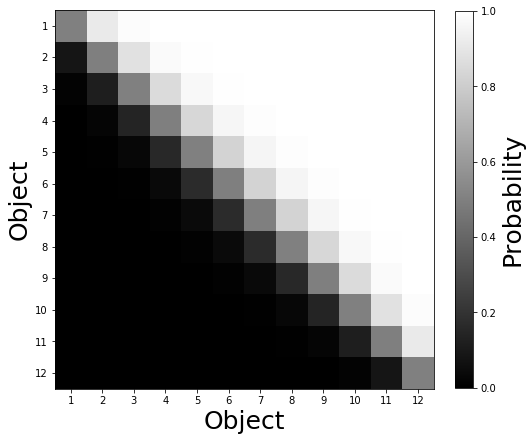

In [76]:
fig =  plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Object', fontsize = 25)
ax.set_ylabel('Object', fontsize = 25)
pos = ax.imshow(Phase_1_decision_matrix, vmin=0, vmax=1, zorder=2, cmap='gray',
                extent=[1,13,1,13], interpolation='nearest', aspect='equal')
ax.set_xticks(np.arange(1.5, 13.5, 1));
ax.set_yticks(np.arange(1.5, 13.5, 1));
ax.set_xticklabels(np.arange(1, 13, 1));
ax.set_yticklabels(np.arange(12, 0, -1));
fig.colorbar(pos, ax=ax, orientation='vertical', fraction=0.045).set_label(label='Probability',size=25,weight='normal')
fig.savefig('I_1_Choice.png')

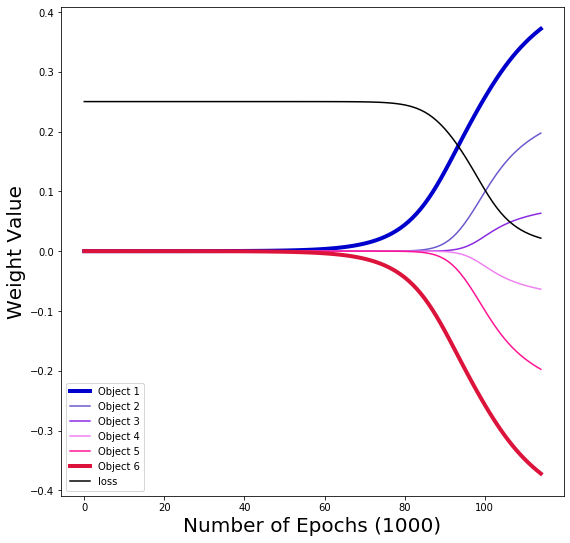

In [35]:
W1_hist_np = Phase_1_w1_history.numpy()
t = np.arange(W1_hist_np.shape[0])

end_point = W1_hist_np.shape[0]

fig =plt.figure(figsize=(9, 9))   
ax = fig.add_subplot(1,1,1) 

ax.plot(t[:end_point], W1_hist_np[:end_point,0,0], color='mediumblue', linewidth = 4, label='Object 1')
ax.plot(t[:end_point], W1_hist_np[:end_point,0,1], color='slateblue', label='Object 2')
ax.plot(t[:end_point], W1_hist_np[:end_point,0,2], color='blueviolet', label='Object 3') 
ax.plot(t[:end_point], W1_hist_np[:end_point,0,3], color='violet', label='Object 4') 
ax.plot(t[:end_point], W1_hist_np[:end_point,0,4], color='deeppink', label='Object 5') 
ax.plot(t[:end_point], W1_hist_np[:end_point,0,5], color='crimson', linewidth = 4 ,label='Object 6')
 


ax.plot(t[:end_point],  Phase_1_loss_array[:end_point], 'k', label='loss')
ax.set_xlabel('Number of Epochs (1000)', fontsize = 20)
ax.set_ylabel('Weight Value', fontsize = 20)
ax.legend()

fig.savefig('H_1_WeightPlot')

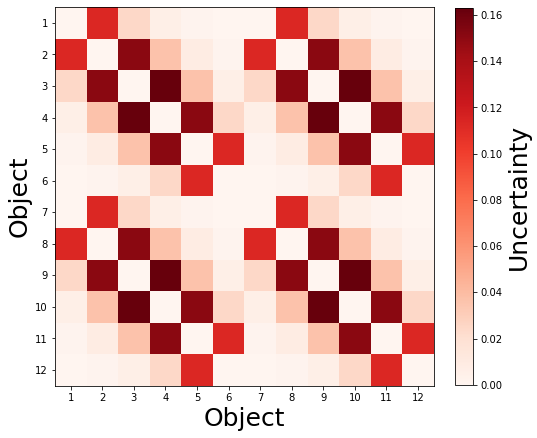

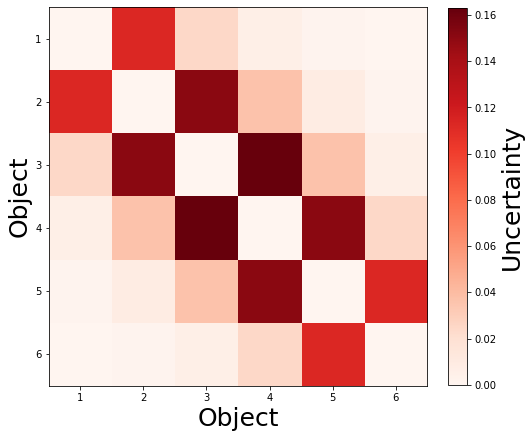

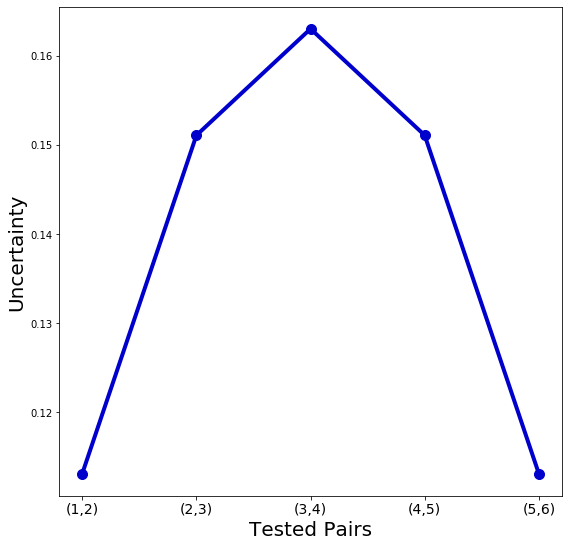

In [111]:
#Plotting the Error (Certainty) Maxtrix for Phase 1
sub_matrix = np.ones((6,6))
for i in range(6):
    sub_matrix[i][i] = 0.5
    if i != 0:
        for j in range(i):
            sub_matrix[i][j] = 0

sub_matrix = np.concatenate((sub_matrix,sub_matrix), axis=1)
Phase_1_target_matrix = np.concatenate((sub_matrix,sub_matrix), axis=0)
Phase_1_error_matrix = np.absolute(Phase_1_target_matrix - Phase_1_decision_matrix )

#Define the error on the long and short diagonals to be zero as otherwise they swamp the off-diagonal scale.
for i in range(12):
    Phase_1_error_matrix[i][i]=0
for i in range(6):
    Phase_1_error_matrix[i][i+6]=0
    Phase_1_error_matrix[i+6][i]=0

fig =  plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Object', fontsize = 25)
ax.set_ylabel('Object', fontsize = 25)
pos = ax.imshow(Phase_1_error_matrix,zorder=2, cmap='Reds', extent=[1,13,1,13], interpolation='nearest', aspect='equal')
ax.set_xticks(np.arange(1.5, 13.5, 1));
ax.set_yticks(np.arange(1.5, 13.5, 1));
ax.set_xticklabels(np.arange(1, 13, 1));
ax.set_yticklabels(np.arange(12, 0, -1));
fig.colorbar(pos, ax=ax, orientation='vertical', fraction=0.045).set_label(label='Uncertainty',size=25,weight='normal')


fig1 =  plt.figure(figsize=(7.5, 7.5))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('Object', fontsize = 25)
ax1.set_ylabel('Object', fontsize = 25)
pos = ax1.imshow(Phase_1_error_matrix[0:6,0:6], zorder=2, extent=[1,7,1,7], cmap='Reds', interpolation='nearest')
ax1.set_xticks(np.arange(1.5, 7.5, 1));
ax1.set_yticks(np.arange(1.5, 7.5, 1));
ax1.set_xticklabels(np.arange(1, 7, 1));
ax1.set_yticklabels(np.arange(6, 0, -1));
fig1.colorbar(pos, ax=ax1, orientation='vertical', fraction=0.045).set_label(label='Uncertainty',size=25,weight='normal') 
 

#fig1.savefig('N_1_Uncertainty_Short.png')
#fig.savefig('N_1_Uncertainty_Small_Full.png')

off_diag_data = np.zeros(5)
for i in range(5):
    off_diag_data[i] = Phase_1_error_matrix[i+1][i]
t = np.arange(5)

fig1 =plt.figure(figsize=(9, 9))   
ax1 = fig1.add_subplot(1,1,1) 
ax1.plot(t ,off_diag_data, color='mediumblue', linewidth = 4, label='Object 1', marker = 'o', markersize=10)
ax1.set_xlabel('Tested Pairs', fontsize = 20)
ax1.set_ylabel('Uncertainty', fontsize = 20)
ax1.set_xticks(np.arange(0,5,1));
ax1.set_xticklabels(['(1,2)','(2,3)','(3,4)','(4,5)','(5,6)'], fontsize=14);
#fig1.savefig('H_1_Diagonal_Uncertainty')

Explained variance: [0.9998 0.0002]


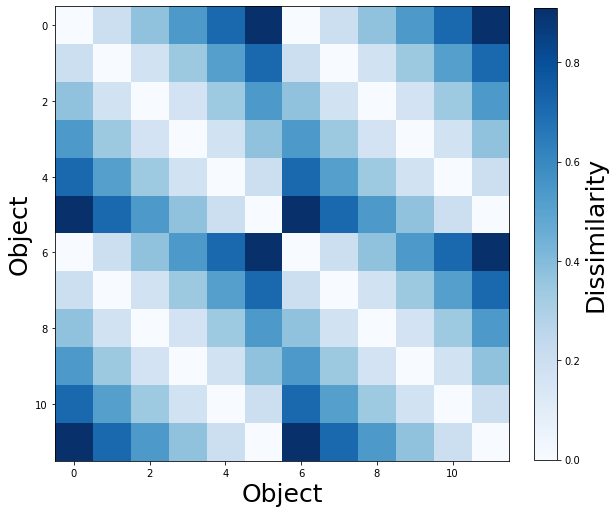

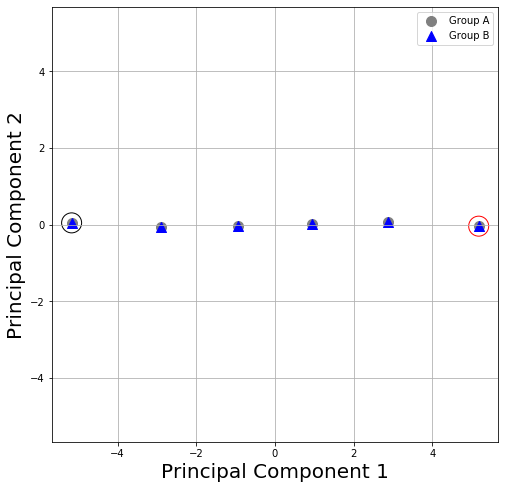

In [68]:
### PCA ###
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

averaged_rep_PCA = 1         #Use =1 to calculate PCA using averaged hidden 

PCA_h1, PCA_test_output = model(Test_x, Test_object_groupings)

#Generating inputs to generate single input hidden representations
single_input_test_x = torch.zeros(12,24)
single_input_test_groupings = torch.zeros(12,4)
for i in range(12):
    single_input_test_x[i][i] = 1
    if i < 6:
        single_input_test_groupings[i][0]=1
    elif i>= 6:
        single_input_test_groupings[i][1]=1
#Calculating the single input hidden representations        
solo_h1, solo_out = model(single_input_test_x,single_input_test_groupings)
    
#Structure the relevant data for PCA and RDM
if hierarchical == 0:
    hidden_np = PCA_h1.detach().numpy()
elif hierarchical == 1:
    hidden_np = torch.cat((PCA_h1, Test_object_groupings),1).detach().numpy()
    
RSA_data = np.zeros((12, hidden_np.shape[1]))

if hierarchical == 0:
    if averaged_rep_PCA ==0:
        RSA_data = solo_h1.detach().numpy()   
    elif averaged_rep_PCA == 1:
        for i in range(12):
            RSA_data[i][:]= np.mean(hidden_np[i*12:(i+1)*12,:], axis=0)
elif hierarchical == 1:
    if averaged_rep_PCA ==0:
        RSA_data_torch = torch.cat((solo_h1, single_input_test_groupings),1)
        RSA_data = RSA_data_torch.detach().numpy()
    elif averaged_rep_PCA == 1:
        for i in range(12):
            RSA_data[i][:]= np.mean(hidden_np[i*12:(i+1)*12,:], axis=0)

###     ###
### PCA ###
x = StandardScaler().fit_transform(RSA_data)
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(x)
pca_var_explained_1 = pca.explained_variance_ratio_[0]
pca_var_explained_2 = pca.explained_variance_ratio_[1]

axis_min = np.min(principal_components-0.5)
axis_max = np.max(principal_components+0.5)

### RDM ###
###     ###
from sklearn.metrics import pairwise_distances

D=pairwise_distances(RSA_data)

fig1 =  plt.figure(figsize=(9, 9))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('Object', fontsize = 25)
ax1.set_ylabel('Object', fontsize = 25)
pos = ax1.imshow(D,zorder=2, cmap='Blues', interpolation='nearest')
fig1.colorbar(pos, ax=ax1, orientation='vertical', fraction=0.045).set_label(label='Dissimilarity',size=25,weight='normal')

print('Explained variance: [{:.4f} {:.4f}]' .format(pca_var_explained_1, pca_var_explained_2)) 
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 20)
ax.set_ylabel('Principal Component 2', fontsize = 20)

for i in range(x.shape[0]):
    if i < 6:
        if i ==0:
            ax.scatter(principal_components[i][0], principal_components[i][1], color='grey', marker = 'o', s=100, label='Group A')
        else:
            ax.scatter(principal_components[i][0], principal_components[i][1], color='grey', marker = 'o', s=100, label=None)
        if i==5:
            ax.scatter(principal_components[i][0], principal_components[i][1], facecolors='none',
                       edgecolors='k', marker = 'o', s=400, label=None)
    elif i >= 6:
        if i == 6:
            ax.scatter(principal_components[i][0], principal_components[i][1], color='blue', marker = '^', s=100, label='Group B')
        else:
            ax.scatter(principal_components[i][0], principal_components[i][1], color='blue', marker = '^', s=100, label=None)
        if i==6:
            ax.scatter(principal_components[i][0], principal_components[i][1], facecolors='none',
                       edgecolors='r', marker = 'o', s=400, label=None)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])
ax.legend()
ax.grid()

#fig.savefig('H_1_PCA.png')
#fig1.savefig('H_1_RDM.png')

In [78]:
#Training on Phase_2 data:
#Initialize W2b
phase_1=0
phase_2 =1

if freezing_regime == 1 and hierarchical == 1:
    model.layer2b.weight.data.uniform_(-weight_scaling, weight_scaling) 
    model.layer2b.weight.requires_grad = True
    model.layer1.weight.requires_grad = False
    model.layer2a.weight.requires_grad = False
    

loss = 1                                       #initialize loss to 1 to get into the while loop.
meta_count_fast =0
meta_count_slow =0
epoch_spill = 0
break_count = 0
loss_array = np.array([])

def add_term_W2b_history(x,y): 
    out = torch.cat((x, torch.unsqueeze(y,0)), 0)
    return out
    
    
loss = 1
switch = 0
meta_count=0

Phase_2_W1_history = torch.tensor([])
Phase_2_W2a_history = torch.tensor([])
Phase_2_W2b_history = torch.tensor([])
Phase_2_loss_array = np.array([])
Phase_2_test_history = np.zeros((1,12,12))
data_matrix_2 = np.zeros((1,12,12))
Phase_2_test_h1_history = torch.tensor([])

learning_rate_1 = 0.1
learning_rate_2 = 0.01
learning_rate_3 = 0.001
learning_rate_4 = 0.0001

t_1_2 = 0.000001
t_2_3 = 0.0001
t_3_4 = 0.01

W1 , W2a, W2b = 0,0,0
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_3, momentum = momentum_rate_2)
W_max = 1

while loss>0.002:
    num_epochs_2 = 1000
         
    for epoch in range(num_epochs_2):  
        
        if W_max <= t_1_2 and switch != 1:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_1, momentum = momentum_rate_2)
            switch =1 
        if t_1_2< W_max <= t_2_3  and switch !=2 :
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_2, momentum = momentum_rate_2)
            switch =2
        if t_2_3 < W_max <= t_3_4  and switch != 3:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_3, momentum = momentum_rate_2)
            switch =3
        if t_3_4 < W_max  and switch != 4:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_4, momentum = momentum_rate_2)
            switch =4
        
        h1, outputs = model(Phase_2_training_x, Phase_2_object_groupings)
        loss = criterion(outputs, Phase_2_training_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
    
        with torch.no_grad():
            if hierarchical == 1:
                W2b_grad = torch.norm(model.layer2b.weight.grad)
                W2b = W2b_grad/np.sqrt(list(model.layer2b.weight.grad.shape)[0]*list(model.layer2b.weight.grad.shape)[1])
           
            if hierarchical == 0 or freezing_regime==0:
                W1_grad = torch.norm(model.layer1.weight.grad)
                W1 = W1_grad/np.sqrt(list(model.layer1.weight.grad.shape)[0]*list(model.layer1.weight.grad.shape)[1])
                W2a_grad = torch.norm(model.layer2a.weight.grad)
                W2a = W2a_grad/np.sqrt(list(model.layer2a.weight.grad.shape)[0]*list(model.layer2a.weight.grad.shape)[1])

        W_max = max(W1,W2a,W2b)
            
        if (epoch+1)%num_epochs_2 ==0:
            with torch.no_grad():
                Phase_2_W1_history = add_term(Phase_2_W1_history, model.layer1.weight)
                Phase_2_W2a_history = add_term(Phase_2_W2a_history, model.layer2a.weight)
                Phase_2_W2b_history = add_term(Phase_2_W2b_history, model.layer2b.weight)

            print ('Phase 2, Index: {}, Epoch {}, Loss:{:.6f},  W_max: {}, switch:{}' 
                   .format(meta_count, epoch+1+meta_count*num_epochs_2, loss.item(), W_max, switch))
            print('\n')
            
            Phase_2_loss_array = np.append(Phase_2_loss_array, np.array([loss]))            
            #Testing during Phase 2 training:
            Phase_2_test_h1 , phase_2_test_output = model(Test_x, Test_object_groupings)         
            Phase_2_test_h1_history = add_term(Phase_2_test_h1_history, Phase_2_test_h1)
            
            #Saving this result
            test_2_y_data = phase_2_test_output.detach().numpy()
            test_2_y_data_1 = test_2_y_data[0:72, 1]
            test_2_y_data_2 = test_2_y_data[72:144, 1]
            for i in range(6):
                data_matrix_2[0][:][i] = test_2_y_data_1[i*12:(i+1)*12]
            for i in range(6):
                data_matrix_2[0][:][i+6] = test_2_y_data_2[i*12:(i+1)*12]
                
            Phase_2_test_history = np.concatenate((Phase_2_test_history, data_matrix_2), axis=0)    
            meta_count+= 1
            
#Testing the data post training for phase 2:
Phase_2_h1, Phase_2_test_output = model(Test_x, Test_object_groupings)            

Phase 2, Index: 0, Epoch 1000, Loss:0.998844,  W_max: 0.000577728555072099, switch:3


Phase 2, Index: 1, Epoch 2000, Loss:0.998816,  W_max: 0.0005913646891713142, switch:3


Phase 2, Index: 2, Epoch 3000, Loss:0.998788,  W_max: 0.0006056725978851318, switch:3


Phase 2, Index: 3, Epoch 4000, Loss:0.998757,  W_max: 0.0006206839461810887, switch:3


Phase 2, Index: 4, Epoch 5000, Loss:0.998726,  W_max: 0.0006364328437484801, switch:3


Phase 2, Index: 5, Epoch 6000, Loss:0.998693,  W_max: 0.000653023598715663, switch:3


Phase 2, Index: 6, Epoch 7000, Loss:0.998658,  W_max: 0.0006704966654069722, switch:3


Phase 2, Index: 7, Epoch 8000, Loss:0.998621,  W_max: 0.0006889477372169495, switch:3


Phase 2, Index: 8, Epoch 9000, Loss:0.998582,  W_max: 0.0007084175013005733, switch:3


Phase 2, Index: 9, Epoch 10000, Loss:0.998540,  W_max: 0.0007290182402357459, switch:3


Phase 2, Index: 10, Epoch 11000, Loss:0.998497,  W_max: 0.0007508601411245763, switch:3


Phase 2, Index: 11, Epoch 12000

Phase 2, Index: 92, Epoch 93000, Loss:0.001839,  W_max: 0.0017598586855456233, switch:3




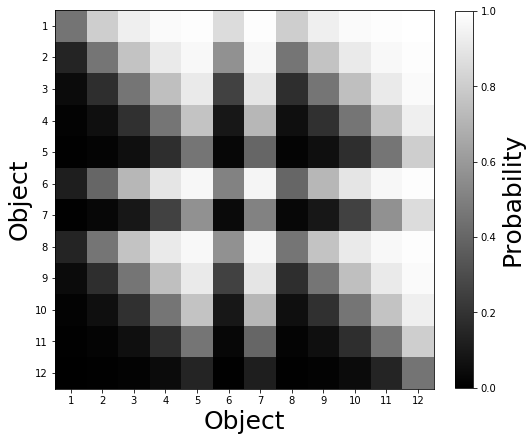

In [70]:
fig =  plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Object', fontsize = 25)
ax.set_ylabel('Object', fontsize = 25)
pos = ax.imshow(Phase_2_test_history[-1][:][:],vmin=0, vmax=1, zorder=2,
                cmap='gray',extent=[1,13,1,13], interpolation='none', aspect='equal')
ax.set_xticks(np.arange(1.5, 13.5, 1));
ax.set_yticks(np.arange(1.5, 13.5, 1));
ax.set_xticklabels(np.arange(1, 13, 1));
ax.set_yticklabels(np.arange(12, 0, -1));
fig.colorbar(pos, ax=ax, orientation='vertical', fraction=0.045).set_label(label='Probability',size=25,weight='normal')
fig.savefig('N_2_Choice')

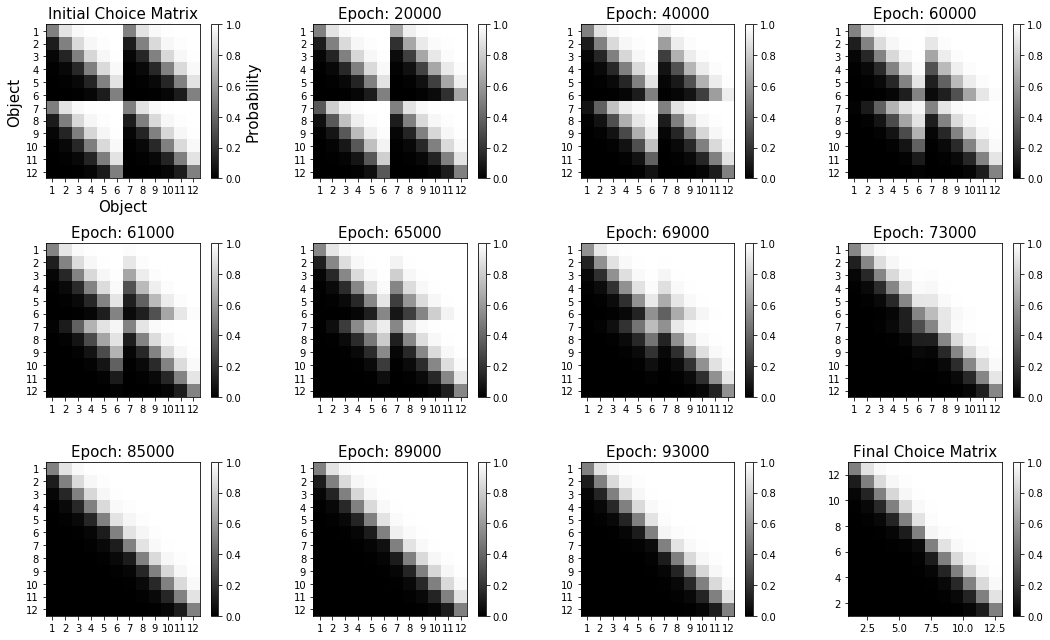

In [88]:
#Plotting the decision matrix during Phase 2 learning
import math
fig, axs = plt.subplots(3,4, figsize=(15, 9))
#fig.subplots_adjust(hspace = .05, wspace=.4)
start_loc = 1
stride_1 = 20
stride_2 = 4
stride_3 = 4


axs = axs.ravel()
for i in range(1):  
    axs[i].set_title('Initial Choice Matrix', fontsize=15)
    pos = axs[i].imshow(Phase_2_test_history[i*stride_1+start_loc][:][:], vmin=0, vmax=1, 
                        zorder=2, cmap='gray',extent=[1,13,1,13], interpolation='nearest', aspect='equal')
    fig.colorbar(pos, ax=axs[i], orientation='vertical', fraction=0.045).set_label(label='Probability',size=15,weight='normal')
    axs[i].set_xticks(np.arange(1.5, 13.5, 1));
    axs[i].set_yticks(np.arange(1.5, 13.5, 1));
    axs[i].set_xticklabels(np.arange(1, 13, 1));
    axs[i].set_yticklabels(np.arange(12, 0, -1));
    axs[i].set_xlabel('Object', fontsize = 15)
    axs[i].set_ylabel('Object', fontsize = 15)
    meta_index = max(0,i*stride_1+start_loc)
for i in range(1,4):  
    axs[i].set_title('Epoch: {}'.format(1000*i*stride_1), fontsize=15)
    pos = axs[i].imshow(Phase_2_test_history[i*stride_1+start_loc][:][:], vmin=0, vmax=1, zorder=2,
                        cmap='gray',extent=[1,13,1,13], interpolation='nearest', aspect='equal')
    fig.colorbar(pos, ax=axs[i], orientation='vertical', fraction=0.045)
    axs[i].set_xticks(np.arange(1.5, 13.5, 1));
    axs[i].set_yticks(np.arange(1.5, 13.5, 1));
    axs[i].set_xticklabels(np.arange(1, 13, 1));
    axs[i].set_yticklabels(np.arange(12, 0, -1));
    meta_index = max(0,i*stride_1+start_loc)
    
for i in range(4,8):  
    axs[i].set_title('Epoch: {}'.format(1000*((i-4)*stride_2+meta_index)), fontsize=15)
    pos = axs[i].imshow(Phase_2_test_history[(i-4)*stride_2+meta_index][:][:], vmin=0, vmax=1,
                        zorder=2, cmap='gray',extent=[1,13,1,13], interpolation='nearest', aspect='equal')
    fig.colorbar(pos, ax=axs[i], orientation='vertical', fraction=0.045)
    axs[i].set_xticks(np.arange(1.5, 13.5, 1));
    axs[i].set_yticks(np.arange(1.5, 13.5, 1));
    axs[i].set_xticklabels(np.arange(1, 13, 1));
    axs[i].set_yticklabels(np.arange(12, 0, -1));
    meta_index_2 = max(0, i*stride+meta_index)
    
for i in range(8,11):  
    axs[i].set_title('Epoch: {}'.format(1000*(meta_count-(10-i)*stride_3)), fontsize=15)
    pos = axs[i].imshow(Phase_2_test_history[meta_count-(10-i)*stride_3][:][:],vmin=0, vmax=1,
                        zorder=2, cmap='gray',extent=[1,13,1,13], interpolation='nearest', aspect='equal')
    fig.colorbar(pos, ax=axs[i], orientation='vertical', fraction=0.045)
    axs[i].set_xticks(np.arange(1.5, 13.5, 1));
    axs[i].set_yticks(np.arange(1.5, 13.5, 1));
    axs[i].set_xticklabels(np.arange(1, 13, 1));
    axs[i].set_yticklabels(np.arange(12, 0, -1));
    meta_index_2 = max(0, i*stride+meta_index)
    
axs[-1].set_title('Final Choice Matrix', fontsize=15)
pos = axs[-1].imshow(Phase_2_test_history[-1][:][:],vmin=0, vmax=1,
                     zorder=2, cmap='gray',extent=[1,13,1,13], interpolation='nearest', aspect='equal')
fig.colorbar(pos, ax=axs[-1], orientation='vertical', fraction=0.045)
fig.tight_layout()
fig.savefig('H_2_Choice_History')

In [112]:
### Phase 3 (ambiguous list linking) ###

#####                                  #####
#####  Create Phase 2 training data:   #####
Phase_3_training_x = torch.zeros(2,24)
Phase_3_training_x[(0,0,1,1),(4,19,7,16)] = 1

Phase_3_training_y = torch.zeros(2,2)
Phase_3_training_y[(0,1),(1,0)]=1

#Training on Phase_2 data:
#Initialize W2b
phase_1=0
phase_2=0
phase_3 =1

if freezing_regime == 1 and hierarchical == 1:
    model.layer2b.weight.data.uniform_(-weight_scaling, weight_scaling) 
    model.layer2b.weight.requires_grad = True
    model.layer1.weight.requires_grad = False
    model.layer2a.weight.requires_grad = False
    

loss = 1                                       #initialize loss to 1 to get into the while loop.
meta_count_fast =0
meta_count_slow =0
epoch_spill = 0
break_count = 0
loss_array = np.array([])

def add_term_W2b_history(x,y): 
    out = torch.cat((x, torch.unsqueeze(y,0)), 0)
    return out
    
    
loss = 1
switch = 0
meta_count=0

Phase_3_W1_history = torch.tensor([])
Phase_3_W2a_history = torch.tensor([])
Phase_3_W2b_history = torch.tensor([])
Phase_3_loss_array = np.array([])
Phase_3_test_history = np.zeros((1,12,12))
data_matrix_3 = np.zeros((1,12,12))
Phase_3_test_h1_history = torch.tensor([])

learning_rate_1 = 0.1
learning_rate_2 = 0.01
learning_rate_3 = 0.001
learning_rate_4 = 0.0001

t_1_2 = 0.000001
t_2_3 = 0.0001
t_3_4 = 0.01

W1 , W2a, W2b = 0,0,0
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_3, momentum = momentum_rate_2)
W_max = 1

while loss>0.002:
    num_epochs_2 = 1000
         
    for epoch in range(num_epochs_2):  
        
        if W_max <= t_1_2 and switch != 1:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_1, momentum = momentum_rate_2)
            switch =1 
        if t_1_2< W_max <= t_2_3  and switch !=2 :
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_2, momentum = momentum_rate_2)
            switch =2
        if t_2_3 < W_max <= t_3_4  and switch != 3:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_3, momentum = momentum_rate_2)
            switch =3
        if t_3_4 < W_max  and switch != 4:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate_4, momentum = momentum_rate_2)
            switch =4
        
        h1, outputs = model(Phase_3_training_x, Phase_2_object_groupings)
        loss = criterion(outputs, Phase_2_training_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
    
        with torch.no_grad():
            if hierarchical == 1:
                W2b_grad = torch.norm(model.layer2b.weight.grad)
                W2b = W2b_grad/np.sqrt(list(model.layer2b.weight.grad.shape)[0]*list(model.layer2b.weight.grad.shape)[1])
           
            if hierarchical == 0 or freezing_regime==0:
                W1_grad = torch.norm(model.layer1.weight.grad)
                W1 = W1_grad/np.sqrt(list(model.layer1.weight.grad.shape)[0]*list(model.layer1.weight.grad.shape)[1])
                W2a_grad = torch.norm(model.layer2a.weight.grad)
                W2a = W2a_grad/np.sqrt(list(model.layer2a.weight.grad.shape)[0]*list(model.layer2a.weight.grad.shape)[1])

        W_max = max(W1,W2a,W2b)
            
        if (epoch+1)%num_epochs_2 ==0:
            with torch.no_grad():
                Phase_3_W1_history = add_term(Phase_3_W1_history, model.layer1.weight)
                Phase_3_W2a_history = add_term(Phase_3_W2a_history, model.layer2a.weight)
                Phase_3_W2b_history = add_term(Phase_3_W2b_history, model.layer2b.weight)

            print ('Phase 2, Index: {}, Epoch {}, Loss:{:.6f},  W_max: {}, switch:{}' 
                   .format(meta_count, epoch+1+meta_count*num_epochs_2, loss.item(), W_max, switch))
            print('\n')
            
            Phase_3_loss_array = np.append(Phase_3_loss_array, np.array([loss]))            
            #Testing during Phase 2 training:
            Phase_3_test_h1 , phase_3_test_output = model(Test_x, Test_object_groupings)         
            Phase_3_test_h1_history = add_term(Phase_3_test_h1_history, Phase_3_test_h1)
            
            #Saving this result
            test_3_y_data = phase_3_test_output.detach().numpy()
            test_3_y_data_1 = test_3_y_data[0:72, 1]
            test_3_y_data_2 = test_3_y_data[72:144, 1]
            for i in range(6):
                data_matrix_3[0][:][i] = test_3_y_data_1[i*12:(i+1)*12]
            for i in range(6):
                data_matrix_3[0][:][i+6] = test_3_y_data_2[i*12:(i+1)*12]
                
            Phase_3_test_history = np.concatenate((Phase_3_test_history, data_matrix_3), axis=0)    
            meta_count+= 1
            
#Testing the data post training for phase 2:
Phase_3_h1, Phase_3_test_output = model(Test_x, Test_object_groupings)            

Phase 2, Index: 0, Epoch 1000, Loss:0.979317,  W_max: 0.010180370882153511, switch:4


Phase 2, Index: 1, Epoch 2000, Loss:0.978455,  W_max: 0.010598042979836464, switch:4


Phase 2, Index: 2, Epoch 3000, Loss:0.977518,  W_max: 0.01105077750980854, switch:4


Phase 2, Index: 3, Epoch 4000, Loss:0.976498,  W_max: 0.01154313050210476, switch:4


Phase 2, Index: 4, Epoch 5000, Loss:0.975383,  W_max: 0.012080422602593899, switch:4


Phase 2, Index: 5, Epoch 6000, Loss:0.974159,  W_max: 0.01266903430223465, switch:4


Phase 2, Index: 6, Epoch 7000, Loss:0.972810,  W_max: 0.0133165642619133, switch:4


Phase 2, Index: 7, Epoch 8000, Loss:0.971316,  W_max: 0.014032099395990372, switch:4


Phase 2, Index: 8, Epoch 9000, Loss:0.969652,  W_max: 0.014826797880232334, switch:4


Phase 2, Index: 9, Epoch 10000, Loss:0.967789,  W_max: 0.015714211389422417, switch:4


Phase 2, Index: 10, Epoch 11000, Loss:0.965689,  W_max: 0.016711238771677017, switch:4


Phase 2, Index: 11, Epoch 12000, Loss:0.96330

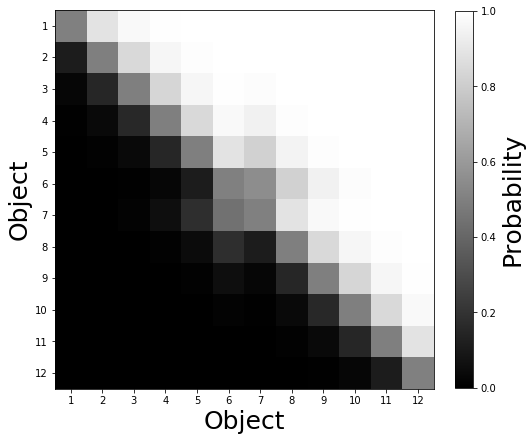

In [113]:
fig =  plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Object', fontsize = 25)
ax.set_ylabel('Object', fontsize = 25)
pos = ax.imshow(Phase_3_test_history[-1][:][:],vmin=0, vmax=1, zorder=2,
                cmap='gray',extent=[1,13,1,13], interpolation='none', aspect='equal')
ax.set_xticks(np.arange(1.5, 13.5, 1));
ax.set_yticks(np.arange(1.5, 13.5, 1));
ax.set_xticklabels(np.arange(1, 13, 1));
ax.set_yticklabels(np.arange(12, 0, -1));
fig.colorbar(pos, ax=ax, orientation='vertical', fraction=0.045).set_label(label='Probability',size=25,weight='normal')
#fig.savefig('H_3_Choice')

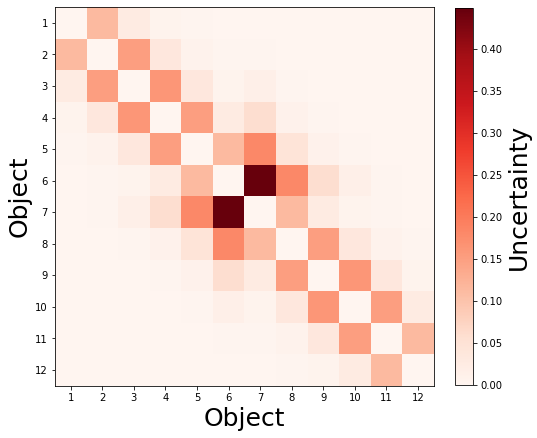

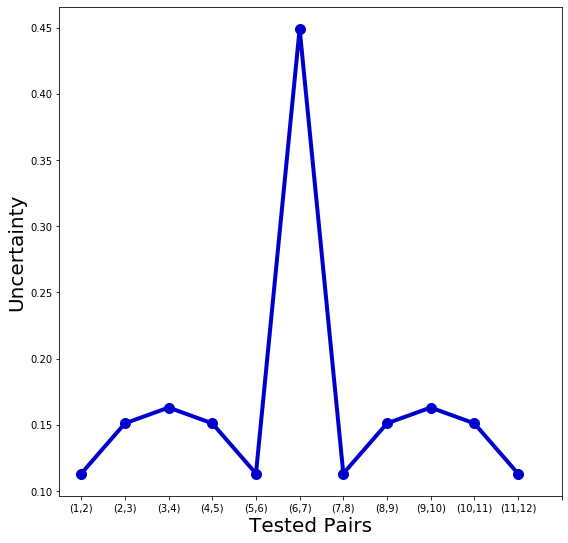

In [114]:
#Calculating Model data
model_h1, model_output = model(Test_x, Test_object_groupings)            
test_3_y_data = model_output.detach().numpy()
test_3_y_data_1 = test_3_y_data[0:72, 1]
test_3_y_data_2 = test_3_y_data[72:144, 1]
data_matrix = np.zeros((12,12))
for i in range(6):
    data_matrix[:][i] = test_3_y_data_1[i*12:(i+1)*12]
for i in range(6):
    data_matrix[:][i+6] = test_3_y_data_2[i*12:(i+1)*12]

uncertainty_matrix = 0.5 - abs(data_matrix-0.5)
for i in range(12):
    uncertainty_matrix[i][i]=0
fig =  plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Object', fontsize = 25)
ax.set_ylabel('Object', fontsize = 25)
pos = ax.imshow(uncertainty_matrix,zorder=2, cmap='Reds', extent=[1,13,1,13], interpolation='nearest', aspect='equal', origin='upper')
ax.set_xticks(np.arange(1.5, 13.5, 1));
ax.set_yticks(np.arange(1.5, 13.5, 1));
ax.set_xticklabels(np.arange(1, 13, 1));
ax.set_yticklabels(np.arange(12, 0, -1));

fig.colorbar(pos, ax=ax, orientation='vertical', fraction=0.045).set_label(label='Uncertainty',size=25,weight='normal')
#fig.savefig('H_3_uncertainty')


off_diag_data = np.zeros(11)
for i in range(11):
    off_diag_data[i] = uncertainty_matrix[i+1][i]
t = np.arange(11)

fig1 =plt.figure(figsize=(9, 9))   
ax1 = fig1.add_subplot(1,1,1) 
ax1.plot(t ,off_diag_data, color='mediumblue', linewidth = 4, label='Object 1', marker = 'o', markersize=10)
ax1.set_xlabel('Tested Pairs', fontsize = 20)
ax1.set_ylabel('Uncertainty', fontsize = 20)
ax1.set_xticks(np.arange(0,12,1));
ax1.set_xticklabels(['(1,2)','(2,3)','(3,4)','(4,5)','(5,6)','(6,7)','(7,8)','(8,9)','(9,10)','(10,11)','(11,12)']);
fig1.savefig('H_3_Diagonal_Uncertainty')

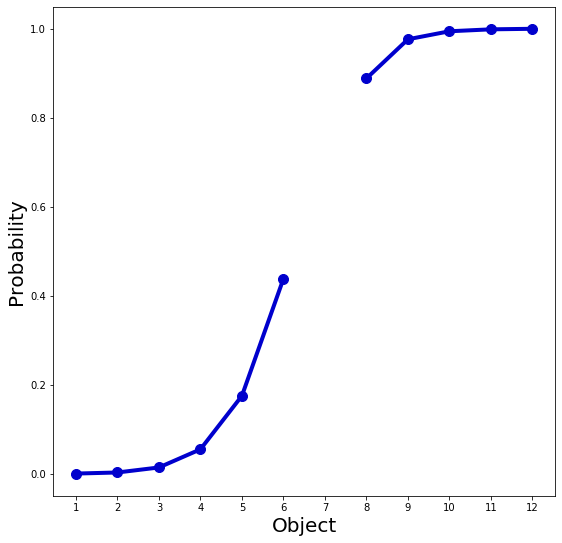

In [65]:
#Plotting choices for 7 for phase 3

phase_3_choice_7 = Phase_3_test_history[-1][:][6]
phase_3_choice_7[6] = np.nan

t = np.arange(12)

fig =plt.figure(figsize=(9, 9))   
ax = fig.add_subplot(1,1,1) 

ax.plot(t ,phase_3_choice_7, color='mediumblue', linewidth = 4, label='Object 1', marker = 'o', markersize=10)
ax.set_xlabel('Object', fontsize = 20)
ax.set_ylabel('Probability', fontsize = 20)
ax.set_xticks(np.arange(0, 12, 1));
ax.set_xticklabels(np.arange(1, 13, 1));
#ax.legend()
#fig.savefig('H_3_7')